In [255]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation,BatchNormalization,Input,Embedding,Dot,Dense,Flatten
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler,TensorBoard,EarlyStopping
from wordcloud import WordCloud
import os
%matplotlib inline

In [256]:
INPUT_DIR=os.path.join('..','artifacts','raw')

In [257]:
rating_df=pd.read_csv(INPUT_DIR+'/animelist.csv',low_memory=True,usecols=['user_id','anime_id','rating'])
rating_df.head()

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


In [258]:
n_ratings=rating_df['user_id'].value_counts()
rating_df=rating_df[rating_df['user_id'].isin(n_ratings[n_ratings>=400].index)].copy()

In [259]:
len(rating_df)

3246641

In [260]:
min_rating=rating_df['rating'].min()
max_rating=rating_df['rating'].max()
avg_rating=np.mean(rating_df['rating'])

In [261]:
rating_df['rating']=rating_df['rating'].apply(lambda x: (x-min_rating)/(max_rating-min_rating)).values.astype('float64')

In [262]:
avg_rating

np.float64(4.122732695114736)

In [263]:
rating_df.duplicated().sum()

np.int64(0)

In [264]:
user_ids=rating_df['user_id'].unique()
user2user_encoded={x: i for i,x in enumerate(user_ids)}
user2user_decoded={i: x for i,x in enumerate(user_ids)}
rating_df['user']=rating_df['user_id'].map(user2user_encoded)

In [265]:
n_users=len(user2user_encoded)

In [266]:
anime_ids=rating_df['anime_id'].unique().tolist()
anime2anime_encoded={x: i for i,x in enumerate(anime_ids)}
anime2anime_decoded={i: x for i,x in enumerate(anime_ids)}
rating_df['anime']=rating_df['anime_id'].map(anime2anime_encoded)

In [267]:
n_animes=len(anime2anime_encoded)

In [268]:
rating_df=rating_df.sample(frac=1,random_state=42).reset_index(drop=True)

In [269]:
x=rating_df[['user','anime']].values
y=rating_df['rating'].values

In [270]:
train_indices=rating_df.shape[0]-1000

In [271]:
x_train,x_test,y_train,y_test=(x[:train_indices],x[train_indices:],y[:train_indices],y[train_indices:])

In [272]:
x_train_array=[x_train[:,0],x_train[:,1]]
x_test_array=[x_test[:,0],x_test[:,1]]

In [273]:
def RecommenderNet():
    embedding_size=128

    user=Input(name='user',shape=[1])
    user_embedding=Embedding(name='user_embedding',input_dim=n_users,output_dim=embedding_size)(user)

    anime=Input(name='anime',shape=[1])
    anime_embedding=Embedding(name='anime_embedding',input_dim=n_animes,output_dim=embedding_size)(anime)

    x=Dot(name='dot_product',normalize=True,axes=2)([user_embedding,anime_embedding])

    x=Flatten()(x)
    x=Dense(1,kernel_initializer='he_normal')(x)
    x=BatchNormalization()(x)
    x=Activation('sigmoid')(x)

    model=Model(inputs=[user,anime],outputs=x)
    model.compile(loss='binary_crossentropy',metrics=['mae','mse'],optimizer='Adam')

    return model

In [274]:
model=RecommenderNet()

In [275]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │    537,984 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,195,072 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │          2 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1)         │          4 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,733,062 (10.43 MB)

 Trainable params: 2,733,060 (10.43 MB)

 Non-trainable params: 2 (8.00 B)

In [276]:
start_lr=0.00001
min_lr=0.0001
max_lr=0.00005
batch_size=10000

ramup_epochs=5
sustain_epochs=0
exp_decay=0.8

def lrfn(epoch):
    if epoch < ramup_epochs:
        lr = start_lr + (max_lr-start_lr)/ramup_epochs*epoch
    elif epoch < ramup_epochs + sustain_epochs:
        lr = max_lr
    else:
        lr = (max_lr-min_lr) * exp_decay ** (epoch - ramup_epochs - sustain_epochs)+min_lr
    return lr

In [277]:
lr_callback=LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=0)
checkpoint_filepath='./weights.weights.h5'

model_checkpoint=ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,monitor='val_loss',mode='min',save_best_only=True)

early_stopping=EarlyStopping(patience=3,monitor='val_loss',mode='min',restore_best_weights=True)

In [278]:
my_callbacks=[model_checkpoint,lr_callback,early_stopping]

In [279]:
history=model.fit(
    x=x_train_array,
    y=y_train,
    batch_size=batch_size,
    epochs=20,
    verbose=1,
    validation_data=(x_test_array,y_test),
    callbacks=my_callbacks
)

Epoch 1/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - loss: 0.7263 - mae: 0.3680 - mse: 0.1706 - val_loss: 0.6957 - val_mae: 0.3649 - val_mse: 0.1582 - learning_rate: 1.0000e-05
Epoch 2/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - loss: 0.7238 - mae: 0.3672 - mse: 0.1695 - val_loss: 0.7136 - val_mae: 0.3701 - val_mse: 0.1668 - learning_rate: 1.8000e-05
Epoch 3/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - loss: 0.7193 - mae: 0.3658 - mse: 0.1676 - val_loss: 0.7276 - val_mae: 0.3731 - val_mse: 0.1730 - learning_rate: 2.6000e-05
Epoch 4/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - loss: 0.7137 - mae: 0.3636 - mse: 0.1650 - val_loss: 0.7244 - val_mae: 0.3725 - val_mse: 0.1715 - learning_rate: 3.4000e-05


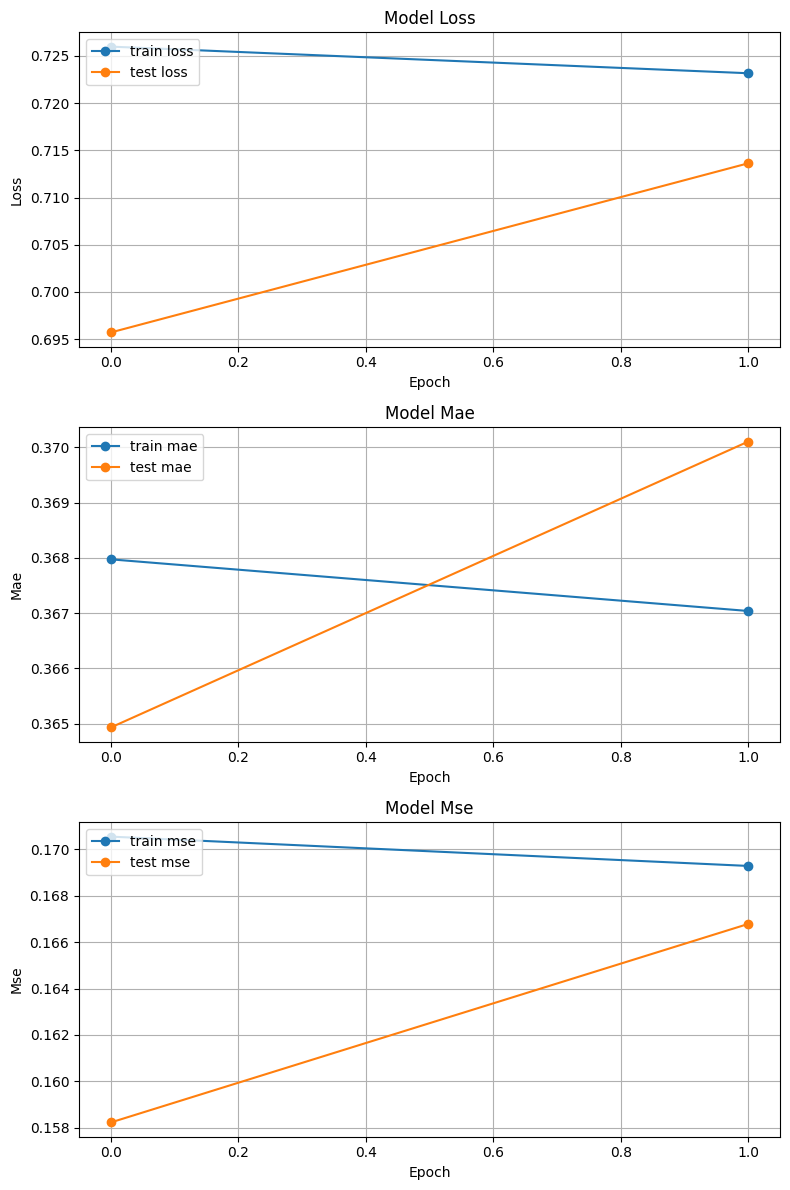

In [280]:
metrics = ["loss", "mae", "mse"]

# Create subplots
fig, axes = plt.subplots(len(metrics), 1, figsize=(8, len(metrics) * 4))

for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.plot(history.history[metric][0:-2], marker="o", label=f"train {metric}")
    ax.plot(history.history[f"val_{metric}"][0:-2], marker="o", label=f"test {metric}")
    ax.set_title(f"Model {metric.capitalize()}")
    ax.set_ylabel(metric.capitalize())
    ax.set_xlabel("Epoch")
    ax.legend(loc="upper left")
    ax.grid(True)

plt.tight_layout()
plt.show()

In [281]:
def extract_weights(name,model):
    weights_layer=model.get_layer(name)
    weights=weights_layer.get_weights()[0]
    weights-weights/np.linalg.norm(weights,axis=1).reshape((-1,1))
    return weights

In [282]:
anime_weights=extract_weights('anime_embedding',model)

In [283]:
user_weights=extract_weights('user_embedding',model)

In [284]:
df=pd.read_csv(INPUT_DIR+'/anime.csv',low_memory=True)
df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,Producers,Licensors,Studios,Source,Duration,Rating,Ranked,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped,Plan to Watch,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,Bandai Visual,"Funimation, Bandai Entertainment",Sunrise,Original,24 min. per ep.,R - 17+ (violence & profanity),28.0,39,1251960,61971,105808,718161,71513,26678,329800,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,"Sunrise, Bandai Visual",Sony Pictures Entertainment,Bones,Original,1 hr. 55 min.,R - 17+ (violence & profanity),159.0,518,273145,1174,4143,208333,1935,770,57964,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,Victor Entertainment,"Funimation, Geneon Entertainment USA",Madhouse,Manga,24 min. per ep.,PG-13 - Teens 13 or older,266.0,201,558913,12944,29113,343492,25465,13925,146918,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, Magic",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,"TV Tokyo, Bandai Visual, Dentsu, Victor Entertainment","Funimation, Bandai Entertainment",Sunrise,Original,25 min. per ep.,PG-13 - Teens 13 or older,2481.0,1467,94683,587,4300,46165,5121,5378,33719,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,"TV Tokyo, Dentsu",Unknown,Toei Animation,Manga,23 min. per ep.,PG - Children,3710.0,4369,13224,18,642,7314,766,1108,3394,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0


In [285]:
df=df.replace('Unknown',np.nan)

In [286]:
def getAnimeName(anime_id):
    try:
        name = df[df.anime_id == anime_id].eng_version.values[0]
        if name is np.nan:
            name = df[df.anime_id == anime_id].Name.values[0]
    except:
        print("Error")
    return name

In [287]:
df["anime_id"] = df["MAL_ID"]
df["eng_version"] = df["English name"]
df["eng_version"] = df.anime_id.apply(lambda x:getAnimeName(x))

In [288]:
getAnimeName(67)

'Basilisk'

In [289]:
df.sort_values(by=['Score'],inplace=True,ascending=False,kind='quicksort',na_position='last')

In [290]:
df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,Producers,Licensors,Studios,Source,Duration,Rating,Ranked,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped,Plan to Watch,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
3971,5114,Fullmetal Alchemist: Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen",Fullmetal Alchemist:Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,TV,64,"Apr 5, 2009 to Jul 4, 2010",Spring 2009,"Aniplex, Square Enix, Mainichi Broadcasting System, Studio Moriken","Funimation, Aniplex of America",Bones,Manga,24 min. per ep.,R - 17+ (violence & profanity),1.0,3,2248456,183914,171871,1644938,75728,32456,323463,714811.0,401507.0,199160.0,70045.0,20210.0,9308.0,3222.0,1536.0,2162.0,16806.0,5114,Fullmetal Alchemist:Brotherhood
15926,40028,Shingeki no Kyojin: The Final Season,9.17,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen",Attack on Titan Final Season,進撃の巨人 The Final Season,TV,16,"Dec 7, 2020 to ?",Winter 2021,"Production I.G, Dentsu, Mainichi Broadcasting System, Pony Canyon, Kodansha, Techno Sound, Pony Canyon Enterprise",Funimation,MAPPA,Manga,23 min. per ep.,R - 17+ (violence & profanity),2.0,119,733260,44862,566239,553,6658,2090,157720,173154.0,63756.0,26016.0,8793.0,2674.0,1336.0,588.0,382.0,514.0,11061.0,40028,Attack on Titan Final Season
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",Steins;Gate,STEINS;GATE,TV,24,"Apr 6, 2011 to Sep 14, 2011",Spring 2011,"Frontier Works, Media Factory, Movic, AT-X, Kadokawa Pictures Japan, Nitroplus",Funimation,White Fox,Visual novel,24 min. per ep.,PG-13 - Teens 13 or older,3.0,9,1771162,148452,114349,1134756,60926,35600,425531,468504.0,275960.0,140914.0,57740.0,21375.0,11126.0,5061.0,2292.0,1678.0,5255.0,9253,Steins;Gate
14963,38524,Shingeki no Kyojin Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Shounen, Super Power",Attack on Titan Season 3 Part 2,進撃の巨人 Season3 Part.2,TV,10,"Apr 29, 2019 to Jul 1, 2019",Spring 2019,"Production I.G, Dentsu, Mainichi Broadcasting System, Pony Canyon, Kodansha, Techno Sound, Pony Canyon Enterprise",Funimation,Wit Studio,Manga,23 min. per ep.,R - 17+ (violence & profanity),4.0,63,1073626,40985,54607,906824,5533,3099,103563,327290.0,239451.0,110481.0,33662.0,8365.0,2974.0,1108.0,550.0,385.0,4169.0,38524,Attack on Titan Season 3 Part 2
9913,28977,Gintama°,9.1,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen",Gintama Season 4,銀魂°,TV,51,"Apr 8, 2015 to Mar 30, 2016",Spring 2015,"TV Tokyo, Aniplex, Dentsu","Funimation, Crunchyroll",Bandai Namco Pictures,Manga,24 min. per ep.,PG-13 - Teens 13 or older,5.0,329,404121,11868,48011,167130,16612,11472,160896,78918.0,37902.0,21360.0,10215.0,3898.0,2311.0,952.0,648.0,1100.0,4508.0,28977,Gintama Season 4


In [291]:
df = df[["anime_id" , "eng_version","Score","Genres","Episodes","Type","Premiered","Members"]]

In [292]:
def getAnimeFrame(anime,df):
    if isinstance(anime,int):
        return df[df.anime_id == anime]
    if isinstance(anime,str):
        return df[df.eng_version == anime]

In [293]:
getAnimeFrame(40028,df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen",16,TV,Winter 2021,733260


In [294]:
cols = ["MAL_ID","Name","Genres","sypnopsis"]

In [295]:
synopsis_df = pd.read_csv(INPUT_DIR+'/anime_with_synopsis.csv',usecols=cols)

In [296]:
synopsis_df.head()

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized several of the planets and moons of the solar system leaving the now uninhabitable surface of planet Earth behind. The Inter Solar System Police attempts to keep peace in the galaxy, aided in part by outlaw bounty hunters, referred to as ""Cowboys."" The ragtag team aboard the spaceship Bebop are two such individuals. Mellow and carefree Spike Spiegel is balanced by his boisterous, pragmatic partner Jet Black as the pair makes a living chasing bounties and collecting rewards. Thrown off course by the addition of new members that they meet in their travels—Ein, a genetically engineered, highly intelligent Welsh Corgi; femme fatale Faye Valentine, an enigmatic trickster with memory loss; and the strange computer whiz kid Edward Wong—the crew embarks on thrilling adventures that unravel each member's dark and mysterious past little by little. Well-balanced with high density action and light-hearted comedy, Cowboy Bebop is a space Western classic and an homage to the smooth and improvised music it is named after."
1,5,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of the often unlucky crew of the Bebop. However, this routine is interrupted when Faye, who is chasing a fairly worthless target on Mars, witnesses an oil tanker suddenly explode, causing mass hysteria. As casualties mount due to a strange disease spreading through the smoke from the blast, a whopping three hundred million woolong price is placed on the head of the supposed perpetrator. With lives at stake and a solution to their money problems in sight, the Bebop crew springs into action. Spike, Jet, Faye, and Edward, followed closely by Ein, split up to pursue different leads across Alba City. Through their individual investigations, they discover a cover-up scheme involving a pharmaceutical company, revealing a plot that reaches much further than the ragtag team of bounty hunters could have realized."
2,6,Trigun,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,000,000 bounty on his head. The reason: he's a merciless villain who lays waste to all those that oppose him and flattens entire cities for fun, garnering him the title ""The Humanoid Typhoon."" He leaves a trail of death and destruction wherever he goes, and anyone can count themselves dead if they so much as make eye contact—or so the rumors say. In actuality, Vash is a huge softie who claims to have never taken a life and avoids violence at all costs. With his crazy doughnut obsession and buffoonish attitude in tow, Vash traverses the wasteland of the planet Gunsmoke, all the while followed by two insurance agents, Meryl Stryfe and Milly Thompson, who attempt to minimize his impact on the public. But soon, their misadventures evolve into life-or-death situations as a group of legendary assassins are summoned to bring about suffering to the trio. Vash's agonizing past will be unraveled and his morality and principles pushed to the breaking point."
3,7,Witch Hunter Robin,"Action, Mystery, Police, Supernatural, Drama, Magic","ches are individuals with special powers like ESP, telekinesis, mind control, etc. Robin, a 15-year-old craft user, arrives from Italy to Japan to work for an organization named STN Japan Division (STN-J) as a replacement for one of STN-J's witch hunters who was recently killed. Unlike other divisions of STN, STN-J tries to capture the witches alive in order to learn why and how they became witches in the first place. (Source: ANN)"
4,8,Bouken Ou Beet,"Adventure, Fantasy, Shounen, Supernatural","It is the dark century and the people are suffering under the rule of the devil, Vandel, who is able to manipulate monsters. The Vandel Busters are a group of people who hunt these devils, and among them, the Zenon Squad is known to be the stronge

In [ ]:
def getSynopsis(anime,df):
    if isinstance(anime,int):
        return df[df.MAL_ID == anime].sypnopsis.values[0]
    if isinstance(anime,str):
        return df[df.Name == anime].sypnopsis.values[0]

In [298]:
synopsis_df['sypnopsis'].fillna('N/A',inplace=True)

/var/folders/_4/16vrzcjs17qdzvw160skhc2c0000gn/T/ipykernel_68675/4079863021.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  synopsis_df['sypnopsis'].fillna('N/A',inplace=True)


In [299]:
getSynopsis(40028,synopsis_df)

"Gabi Braun and Falco Grice have been training their entire lives to inherit one of the seven titans under Marley's control and aid their nation in eradicating the Eldians on Paradis. However, just as all seems well for the two cadets, their peace is suddenly shaken by the arrival of Eren Yeager and the remaining members of the Survey Corps. Having finally reached the Yeager family basement and learned about the dark history surrounding the titans, the Survey Corps has at long last found the answer they so desperately fought to uncover. With the truth now in their hands, the group set out for the world beyond the walls. In Shingeki no Kyojin: The Final Season , two utterly different worlds collide as each party pursues its own agenda in the long-awaited conclusion to Paradis' fight for freedom."

In [300]:
pd.set_option('max_colwidth', None)

In [347]:
def find_similar_animes(name,anime_weights,anime2anime_encoded,anime2anime_decoded,df,synopsis_df,n=10,return_dist=False,neg=False):
    try:
        index=getAnimeFrame(name,df).anime_id.values[0]
        encoded_index=anime2anime_encoded.get(index)
        weights=anime_weights
        dists=np.dot(weights,weights[encoded_index])
        sorted_dists=np.argsort(dists)
        n=n+1
        if neg:
            closest=sorted_dists[:n]
        else:
            closest=sorted_dists[-n:]
        
        if return_dist:
            return dists,closest
        
        SimilarityArr=[]

        for close in closest:
            decoded_id=anime2anime_decoded.get(close)
            anime_frame=getAnimeFrame(decoded_id,df)
            anime_name = anime_frame.eng_version.values[0]
            genre = anime_frame.Genres.values[0]
            similarity = dists[close]

            SimilarityArr.append({
                "anime_id": decoded_id,
                "name": anime_name,
                "similarity": similarity,
                "genre": genre
            })
        Frame=pd.DataFrame(SimilarityArr).sort_values(by='similarity',ascending=False)
        return Frame[Frame.anime_id != index].drop(['anime_id'],axis=1)
    except Exception as e:
        print('Error Occured:',e)



In [302]:
find_similar_animes('Steins;Gate',anime_weights,anime2anime_encoded,anime2anime_decoded,df,synopsis_df)

,name,similarity,genre,synopsis
9,D-1 Devastator,0.040133,"Mecha, Sci-Fi","To follow in his missing friend Masato's footsteps, Ryo joined the vehicle company Yaesu. Ryo became involved with the Makuhari test course that Masato was also a part of. The leader, Gray Gear, told Ryo, ""If you want to know about Masato, come to the test course late at night and ride the new machine."" When Ryo got in the new machine, the Vector Versus, and rode it around the course, he was able to exceed 300 kilometers per hour and suddenly warped into a mysterious space!"
8,Nanatsu no Bitoku Specials,0.034252,"Ecchi, Fantasy",Unaired episodes included with the Blu-ray and DVD release of Nanatsu no Bitoku .
7,Tamala 2010:A Punk Cat in Space,0.034115,"Comedy, Dementia, Psychological, Sci-Fi","In the year 2010, practically one hundred percent of Cat Earth's GDP comes from the megacorporation Catty & Co., which is rapidly spreading across the rest of the galaxy. Here lives Tamala, a beautiful yet foul-mouthed cat, who decides to travel to the planet of her birth, Orion. After an unfortunate crash landing on the planet Q, Tamala meets Michaelangelo, a fellow cat, whom Tamala refers to as ""MoiMoi."" As Tamala and Michaelangelo explore the planet's capital, Hate City—which is under martial law to separate the feuding cat and dog populations—they pass by graffiti and museum exhibits about the ancient cult of Minerva that speak of something dark and sinister. After Tamala catches the eye of the extremely violent motorcycle-riding Kentauros, she and Michaelangelo flee, but mysteries about Tamala's identity continue to surface. Why did Tamala originally leave Orion, and what exactly is her connection to Catty & Co.?"
6,Na Sa Er Ding,0.032740,"Adventure, Demons, Fantasy","In the depths of a vast western desert exists a terrible sand devil. He is bent on turning the forests, rivers, grasslands, and oases of the Western Regions into barren deserts under his rule. In order to save the inhabitants and prevent desertification, a group of young adventurers sets out to the Kunlun Mountains to find the legendary Hu Poplar King and curb the spread of sand. (Source: Kan Sogou)"
5,Cherry Blossom,0.032579,"Kids, Drama",ducational anime about what people should do when faced with discrimination against them in Japan. Aimed at middle schoolers.
4,March Comes In Like A Lion 2nd Season,0.031901,"Drama, Game, Seinen, Slice of Life","Now in his second year of high school, Rei Kiriyama continues pushing through his struggles in the professional shogi world as well as his personal life. Surrounded by vibrant personalities at the shogi hall, the school club, and in the local community, his solitary shell slowly begins to crack. Among them are the three Kawamoto sisters—Akari, Hinata, and Momo—who forge an affectionate and familial bond with Rei. Through these ties, he realizes that everyone is burdened by their own emotional hardships and begins learning how to rely on others while supporting them in return. Nonetheless, the life of a professional is not easy. Between tournaments, championships, and title matches, the pressure mounts as Rei advances through the ranks and encounters incredibly skilled opponents. As he manages his relationships with those who have grown close to him, the shogi player continues to search for the reason he plays the game that defines his career."
3,GA: Geijutsuka Art Design Class,0.031134,"Slice of Life, Comedy, School, Seinen","The Ayanoi High School features the Geijutsuka Art Design Class (GA) that focuses on the arts. Five close friends — the energetic ""hime""-prankster Noda Miki; the level-headed, cynical Nozaki Namiko; the intelligent, observant, and kind Oomichi Miyabi; the lively and mischievous tomboy Tomokane; and the curious, innocent, glasses-wearing Yamaguchi Kisaragi — attend this class with great enthusiasm, learning about the many art techniques. Every day seems to pose a new and interesting challenge, be it struggling with the lates

In [303]:
def find_similar_users(item_input,user_weights,user2user_encoded,user2user_decoded,n=10,return_dist=False,neg=False):
    try:
        index=item_input
        encoded_index=user2user_encoded.get(index)

        weights=user_weights

        dists=np.dot(weights,weights[encoded_index])
        sorted_dists=np.argsort(dists)
        n=n+1
        if neg:
            closest=sorted_dists[:n]
        else:
            closest=sorted_dists[-n:]
        
        if return_dist:
            return dists,closest
        
        SimilarityArr=[]

        for close in closest:
            similarity = dists[close]

            if isinstance(item_input,int):
                decoded_id = user2user_decoded.get(close)
                SimilarityArr.append({
                    "similar_users" : decoded_id,
                    "similarity" : similarity
                })
        similar_users = pd.DataFrame(SimilarityArr).sort_values(by="similarity",ascending=False)
        similar_users = similar_users[similar_users.similar_users != item_input]
        return similar_users
    except Exception as e:
        print("Error Occured",e)


In [304]:
find_similar_users(int(11879),user_weights,user2user_encoded,user2user_decoded)

,similar_users,similarity
9,13216,0.030237
8,13188,0.030066
7,9568,0.028638
6,3922,0.028417
5,4409,0.028070
4,11479,0.027887
3,4018,0.027745
2,577,0.027680
1,10642,0.027631
0,16390,0.027600


In [305]:
def showWordCloud(all_genres):
    genres_cloud=WordCloud(width=700,height=400,background_color='white',colormap='gnuplot').generate_from_frequencies(all_genres)
    plt.figure(figsize=(10,8))
    plt.imshow(genres_cloud,interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [306]:
from collections import defaultdict

In [313]:
def getFavGenre(frame,plot=False):
    frame.dropna(inplace=False)
    all_genres=defaultdict(int)
    genres_list=[]
    for genres in frame['Genres']:
        if isinstance(genres,str):
            for genre in genres.split(','):
                genres_list.append(genre)
                all_genres[genre.strip()]+=1

    if plot:
        showWordCloud(all_genres)
    return genres_list


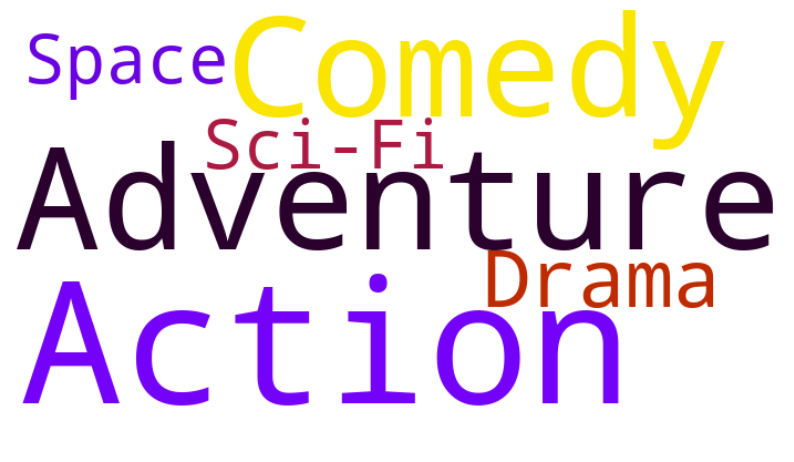

['Action', ' Adventure', ' Comedy', ' Drama', ' Sci-Fi', ' Space']

In [315]:
xf=getAnimeFrame(1,df)
getFavGenre(xf,plot=True)

In [ ]:
def get_user_preferences(user_id,rating_df,df,plot=False):
    animes_watched_by_user=rating_df[rating_df.user_id==user_id]
    user_rating_percentile=np.percentile(animes_watched_by_user.rating,75)
    animes_watched_by_user=animes_watched_by_user[animes_watched_by_user.rating>=user_rating_percentile]
    top_animes_user=(
        animes_watched_by_user.sort_values(by='rating',ascending=False).anime_id.values
    )
    anime_df_rows = df[df["anime_id"].isin(top_animes_user)]
    anime_df_rows=anime_df_rows[['eng_version','Genres']]

    if plot:
        getFavGenre(anime_df_rows,plot)
    return anime_df_rows

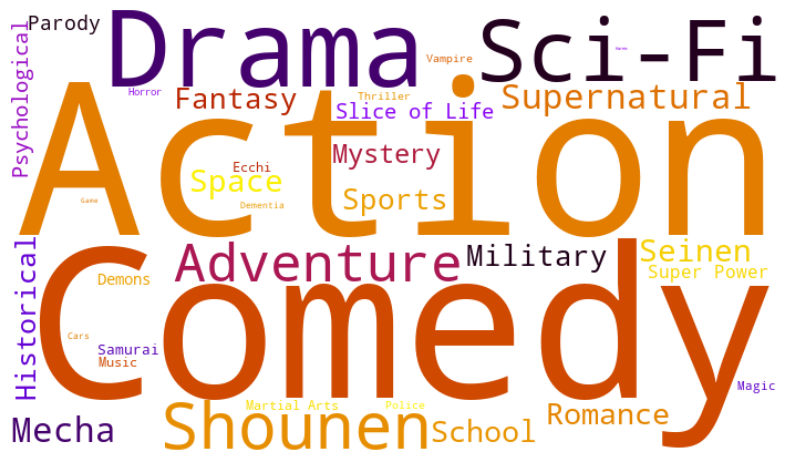

,eng_version,Genres
3971,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen"
9913,Gintama Season 4,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
6474,Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power"
6006,Gintama Season 2,"Action, Sci-Fi, Comedy, Historical, Parody, Samurai, Shounen"
741,Legend of the Galactic Heroes,"Military, Sci-Fi, Space, Drama"
...,...,...
2575,Shootfighter Tekken,"Action, Martial Arts, Shounen"
8064,Samurai Flamenco,"Action, Comedy, Parody, Super Power"
510,Venus Wars,"Action, Sci-Fi, Adventure, Space"
6864,Saint Seiya Omega,"Action, Adventure, Fantasy, Shounen"


In [324]:
get_user_preferences(11880 , rating_df, df , plot=True)

In [343]:
def get_user_recommendations(similar_users,user_pref,df,synopsis_df,rating_df,n=10):
    recommended_anime=[]
    anime_list=[]

    for user_id in similar_users.similar_users.values:
        pref_list=get_user_preferences(int(user_id),rating_df,df)

        pref_list=pref_list[~pref_list.eng_version.isin(user_pref.eng_version.values)]

        if not pref_list.empty:
            anime_list.append(pref_list.eng_version.values)
        
    if anime_list:
        anime_list=pd.DataFrame(anime_list)
        sorted_list = pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(n)
        for i,anime_name in enumerate(sorted_list.index):
            n_user_pref=sorted_list[sorted_list.index==anime_name].values[0][0]

            if isinstance(anime_name,str):
                frame=getAnimeFrame(anime_name,df)
                anime_id=frame.anime_id.values[0].tolist()
                genre=frame.Genres.values[0]
                synopsis=getSynopsis(anime_id,synopsis_df)

                recommended_anime.append({
                    'n':n_user_pref,
                    'anime_name':anime_name,
                    'Genres':genre,
                    'Synopsis':synopsis
                })
    
    return pd.DataFrame(recommended_anime).head(n)

In [326]:
similar_users =find_similar_users(int(11880),user_weights,user2user_encoded,user2user_decoded)

In [327]:
user_pref = get_user_preferences(11880 , rating_df, df , plot=False)

In [342]:
get_user_recommendations(similar_users,user_pref,df, synopsis_df,rating_df)

,n,anime name,Genres,Synopsis
0,9,Angel Beats!,"Action, Comedy, Drama, School, Supernatural","Otonashi awakens only to learn he is dead. A rifle-toting girl named Yuri explains that they are in the afterlife, and Otonashi realizes the only thing he can remember about himself is his name. Yuri tells him that she leads the Shinda Sekai Sensen (Afterlife Battlefront) and wages war against a girl named Tenshi. Unable to believe Yuri's claims that Tenshi is evil, Otonashi attempts to speak with her, but the encounter doesn't go as he intended. Otonashi decides to join the SSS and battle Tenshi, but he finds himself oddly drawn to her. While trying to regain his memories and understand Tenshi, he gradually unravels the mysteries of the afterlife."
1,9,Toradora!,"Slice of Life, Comedy, Romance, School","uuji Takasu is a gentle high school student with a love for housework; but in contrast to his kind nature, he has an intimidating face that often gets him labeled as a delinquent. On the other hand is Taiga Aisaka, a small, doll-like student, who is anything but a cute and fragile girl. Equipped with a wooden katana and feisty personality, Taiga is known throughout the school as the ""Palmtop Tiger."" One day, an embarrassing mistake causes the two students to cross paths. Ryuuji discovers that Taiga actually has a sweet side: she has a crush on the popular vice president, Yuusaku Kitamura, who happens to be his best friend. But things only get crazier when Ryuuji reveals that he has a crush on Minori Kushieda—Taiga's best friend! Toradora! is a romantic comedy that follows this odd duo as they embark on a quest to help each other with their respective crushes, forming an unlikely alliance in the process."
2,9,Your Lie in April,"Drama, Music, Romance, School, Shounen","usic accompanies the path of the human metronome, the prodigious pianist Kousei Arima. But after the passing of his mother, Saki Arima, Kousei falls into a downward spiral, rendering him unable to hear the sound of his own piano. Two years later, Kousei still avoids the piano, leaving behind his admirers and rivals, and lives a colorless life alongside his friends Tsubaki Sawabe and Ryouta Watari. However, everything changes when he meets a beautiful violinist, Kaori Miyazono, who stirs up his world and sets him on a journey to face music again. Based on the manga series of the same name, Shigatsu wa Kimi no Uso approaches the story of Kousei's recovery as he discovers that music is more than playing each note perfectly, and a single melody can bring in the fresh spring air of April."
3,8,Steins;Gate,"Thriller, Sci-Fi","The self-proclaimed mad scientist Rintarou Okabe rents out a room in a rickety old building in Akihabara, where he indulges himself in his hobby of inventing prospective ""future gadgets"" with fellow lab members: Mayuri Shiina, his air-headed childhood friend, and Hashida Itaru, a perverted hacker nicknamed ""Daru."" The three pass the time by tinkering with their most promising contraption yet, a machine dubbed the ""Phone Microwave,"" which performs the strange function of morphing bananas into piles of green gel. Though miraculous in itself, the phenomenon doesn't provide anything concrete in Okabe's search for a scientific breakthrough; that is, until the lab members are spurred into action by a string of mysterious happenings before stumbling upon an unexpected success—the Phone Microwave can send emails to the past, altering the flow of history. Adapted from the critically acclaimed visual novel by 5pb. and Nitroplus, Steins;Gate takes Okabe through the depths of scientific theory and practicality. Forced across the diverging threads of past and present, Okabe must shoulder the burdens that come with holding the key to the realm of time."
4,8,"Love, Chunibyo & Other Delusions!","Slice of Life, Comedy, Drama, Romance, School","Everybody has had that stage in their life where they have thought themselves to be special, different from the masses of o

In [350]:
def hybrid_recommendation(user_id,user_weight=0.3,content_weight=0.7,n=10):
    similar_users =find_similar_users(user_id,user_weights,user2user_encoded,user2user_decoded,n)
    user_pref = get_user_preferences(user_id , rating_df, df)
    user_recommended_animes =get_user_recommendations(similar_users,user_pref,df, synopsis_df,rating_df,n)
    
    user_recommended_animes_list=user_recommended_animes.anime_name.tolist()
    
    content_recommended_animes=[]
    for anime in user_recommended_animes_list:
        similar_animes = find_similar_animes(anime, anime_weights, anime2anime_encoded, anime2anime_decoded, df, synopsis_df,n)

        if similar_animes is not None and not similar_animes.empty:
            content_recommended_animes.extend(similar_animes.name.tolist())
        else:
            print(f'No similar anime found for {anime}')

    combined_scores={}

    for anime in user_recommended_animes_list:
        combined_scores[anime]=combined_scores.get(anime,0)+user_weight
    for anime in content_recommended_animes:
        combined_scores[anime]=combined_scores.get(anime,0)+content_weight
    
    sorted_animes=sorted(combined_scores.items(),key=lambda x: x[1],reverse=True)

    return [anime for anime,_ in sorted_animes[:n]]

In [351]:
hybrid_recommendation(15597)

['Watashi no Kamifuusen (1983)',
 'Gisoku no Moses',
 'Slippy Dandy',
 'Lagrange:The Flower of Rin-ne – Kamogawa Days',
 'Shobo Kujira Chibi Cobra',
 'Hello Kitty no Shiawase no Aoi Hotaru',
 'Free!: Dive to the Future',
 'Deadly Response',
 'The Undertaker and the Dog',
 'Factory']